In [1]:
import torch # pytorch backend
import torchvision # CV models
import pygmtools as pygm
import matplotlib.pyplot as plt # for plotting
from matplotlib.patches import ConnectionPatch # for plotting matching result
import scipy.io as sio # for loading .mat file
import scipy.spatial as spa # for Delaunay triangulation
from sklearn.decomposition import PCA as PCAdimReduc
import itertools
import numpy as np
from PIL import Image
pygm.BACKEND = 'pytorch' # set default backend for pygmtools

/home/dl2022/yyr/.conda/jittor/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
obj_resize = (256, 256)
img1 = Image.open('./data/WillowObject/WILLOW-ObjectClass/Duck/060_0001.png')
img2 = Image.open('./data/WillowObject/WILLOW-ObjectClass/Duck/060_0002.png')
kpts1 = torch.tensor(sio.loadmat('./data/WillowObject/WILLOW-ObjectClass/Duck/060_0001.mat')['pts_coord'])
kpts2 = torch.tensor(sio.loadmat('./data/WillowObject/WILLOW-ObjectClass/Duck/060_0002.mat')['pts_coord'])
kpts1[0] = kpts1[0] * obj_resize[0] / img1.size[0]
kpts1[1] = kpts1[1] * obj_resize[1] / img1.size[1]
kpts2[0] = kpts2[0] * obj_resize[0] / img2.size[0]
kpts2[1] = kpts2[1] * obj_resize[1] / img2.size[1]
img1 = img1.resize(obj_resize, resample=Image.BILINEAR)
img2 = img2.resize(obj_resize, resample=Image.BILINEAR)
torch_img1 = torch.from_numpy(np.array(img1, dtype=np.float32) / 256).permute(2, 0, 1).unsqueeze(0) # shape: BxCxHxW
torch_img2 = torch.from_numpy(np.array(img2, dtype=np.float32) / 256).permute(2, 0, 1).unsqueeze(0) # shape: BxCxHxW

/home/dl2022/yyr/.conda/jittor/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  # Remove the CWD from sys.path while we load stuff.
/home/dl2022/yyr/.conda/jittor/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
print(img)

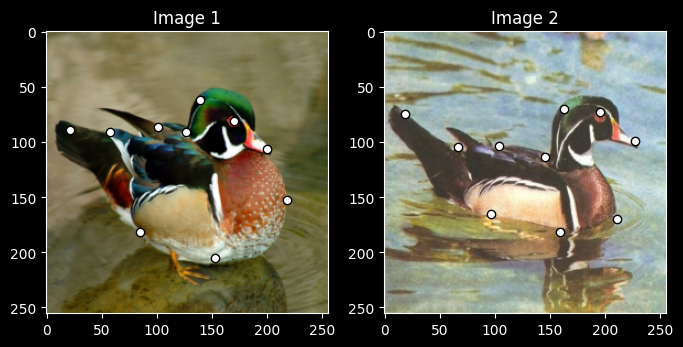

In [13]:
def plot_image_with_graph(img, kpt, A=None):
    plt.imshow(img)
    plt.scatter(kpt[0], kpt[1], c='w', edgecolors='k')
    if A is not None:
        for idx in torch.nonzero(A, as_tuple=False):
            plt.plot((kpt[0, idx[0]], kpt[0, idx[1]]), (kpt[1, idx[0]], kpt[1, idx[1]]), 'k-')

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Image 1')
plot_image_with_graph(img1, kpts1)
plt.subplot(1, 2, 2)
plt.title('Image 2')
plot_image_with_graph(img2, kpts2)

In [14]:
def delaunay_triangulation(kpt):
    d = spa.Delaunay(kpt.numpy().transpose())
    A = torch.zeros(len(kpt[0]), len(kpt[0]))
    for simplex in d.simplices:
        for pair in itertools.permutations(simplex, 2):
            A[pair] = 1
    return A

A1 = delaunay_triangulation(kpts1)
A2 = delaunay_triangulation(kpts2)

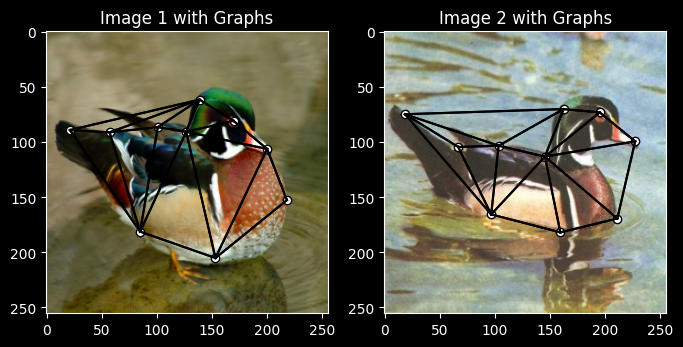

In [15]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Image 1 with Graphs')
plot_image_with_graph(img1, kpts1, A1)
plt.subplot(1, 2, 2)
plt.title('Image 2 with Graphs')
plot_image_with_graph(img2, kpts2, A2)

In [16]:
vgg16_cnn = torchvision.models.vgg16_bn(True)

In [17]:
print(vgg16_cnn.features)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [18]:
class CNNNet(torch.nn.Module):
    def __init__(self, vgg16_module):
        super(CNNNet, self).__init__()
        # The naming of the layers follow ThinkMatch convention to load pretrained models.
        self.node_layers = torch.nn.Sequential(*[_ for _ in vgg16_module.features[:31]])
        self.edge_layers = torch.nn.Sequential(*[_ for _ in vgg16_module.features[31:38]])

    def forward(self, inp_img):
        feat_local = self.node_layers(inp_img)
        feat_global = self.edge_layers(feat_local)
        return feat_local, feat_global

In [21]:
cnn = CNNNet(vgg16_cnn)
path = '/home/dl2022/yyr/Cache/pretrained_params_vgg16_pca_voc.pt'
#path = pygm.utils.download('vgg16_pca_voc_pytorch.pt', 'https://drive.google.com/u/0/uc?export=download&confirm=Z-AR&id=1JnX3cSPvRYBSrDKVwByzp7CADgVCJCO_')
if torch.cuda.is_available():
    map_location = torch.device('cuda:0')
else:
    map_location = torch.device('cpu')
cnn.load_state_dict(torch.load(path, map_location=map_location), strict=False)
with torch.set_grad_enabled(False):
    feat1_local, feat1_global = cnn(torch_img1)
    feat2_local, feat2_global = cnn(torch_img2)

In [23]:
def l2norm(node_feat):
    return torch.nn.functional.local_response_norm(
        node_feat, node_feat.shape[1] * 2, alpha=node_feat.shape[1] * 2, beta=0.5, k=0)

feat1_local = l2norm(feat1_local)
feat1_global = l2norm(feat1_global)
feat2_local = l2norm(feat2_local)
feat2_global = l2norm(feat2_global)

In [24]:
feat1_local_upsample = torch.nn.functional.interpolate(feat1_local, obj_resize, mode='bilinear')
feat1_global_upsample = torch.nn.functional.interpolate(feat1_global, obj_resize, mode='bilinear')
feat2_local_upsample = torch.nn.functional.interpolate(feat2_local, obj_resize, mode='bilinear')
feat2_global_upsample = torch.nn.functional.interpolate(feat2_global, obj_resize, mode='bilinear')
feat1_upsample = torch.cat((feat1_local_upsample, feat1_global_upsample), dim=1)
feat2_upsample = torch.cat((feat2_local_upsample, feat2_global_upsample), dim=1)
num_features = feat1_upsample.shape[1]

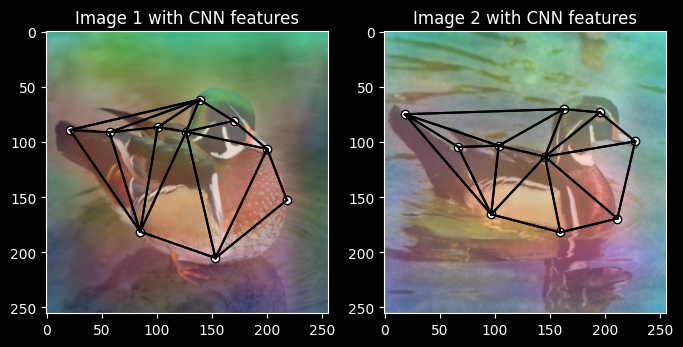

In [25]:
pca_dim_reduc = PCAdimReduc(n_components=3, whiten=True)
feat_dim_reduc = pca_dim_reduc.fit_transform(
    np.concatenate((
        feat1_upsample.permute(0, 2, 3, 1).reshape(-1, num_features).numpy(),
        feat2_upsample.permute(0, 2, 3, 1).reshape(-1, num_features).numpy()
    ), axis=0)
)
feat_dim_reduc = feat_dim_reduc / np.max(np.abs(feat_dim_reduc), axis=0, keepdims=True) / 2 + 0.5
feat1_dim_reduc = feat_dim_reduc[:obj_resize[0] * obj_resize[1], :]
feat2_dim_reduc = feat_dim_reduc[obj_resize[0] * obj_resize[1]:, :]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Image 1 with CNN features')
plot_image_with_graph(img1, kpts1, A1)
plt.imshow(feat1_dim_reduc.reshape(obj_resize[0], obj_resize[1], 3), alpha=0.5)
plt.subplot(1, 2, 2)
plt.title('Image 2 with CNN features')
plot_image_with_graph(img2, kpts2, A2)
plt.imshow(feat2_dim_reduc.reshape(obj_resize[0], obj_resize[1], 3), alpha=0.5)

In [26]:
rounded_kpts1 = torch.round(kpts1).to(dtype=torch.long)
rounded_kpts2 = torch.round(kpts2).to(dtype=torch.long)
node1 = feat1_upsample[0, :, rounded_kpts1[0], rounded_kpts1[1]].t() # shape: NxC
node2 = feat2_upsample[0, :, rounded_kpts2[0], rounded_kpts2[1]].t() # shape: NxC

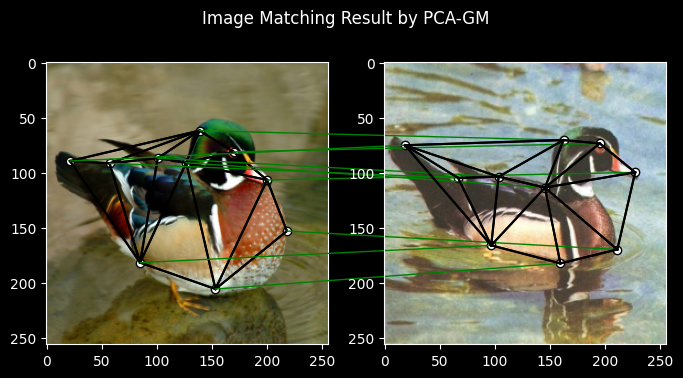

In [27]:
X = pygm.pca_gm(node1, node2, A1, A2, pretrain='voc')
X = pygm.hungarian(X)

plt.figure(figsize=(8, 4))
plt.suptitle('Image Matching Result by PCA-GM')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img1, kpts1, A1)
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img2, kpts2, A2)
for i in range(X.shape[0]):
    j = torch.argmax(X[i]).item()
    con = ConnectionPatch(xyA=kpts1[:, i], xyB=kpts2[:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)

In [28]:
path = '/home/dl2022/yyr/Cache/pretrained_params_vgg16_ipca_voc.pt'
#path = pygm.utils.download('vgg16_ipca_voc_pytorch.pt', 'https://drive.google.com/u/0/uc?export=download&confirm=Z-AR&id=1TGrbSQRmUkClH3Alz2OCwqjl8r8gf5yI')
cnn.load_state_dict(torch.load(path, map_location=map_location), strict=False)

with torch.set_grad_enabled(False):
    feat1_local, feat1_global = cnn(torch_img1)
    feat2_local, feat2_global = cnn(torch_img2)

In [29]:
def l2norm(node_feat):
    return torch.nn.functional.local_response_norm(
        node_feat, node_feat.shape[1] * 2, alpha=node_feat.shape[1] * 2, beta=0.5, k=0)

feat1_local = l2norm(feat1_local)
feat1_global = l2norm(feat1_global)
feat2_local = l2norm(feat2_local)
feat2_global = l2norm(feat2_global)

In [30]:
feat1_local_upsample = torch.nn.functional.interpolate(feat1_local, obj_resize, mode='bilinear')
feat1_global_upsample = torch.nn.functional.interpolate(feat1_global, obj_resize, mode='bilinear')
feat2_local_upsample = torch.nn.functional.interpolate(feat2_local, obj_resize, mode='bilinear')
feat2_global_upsample = torch.nn.functional.interpolate(feat2_global, obj_resize, mode='bilinear')
feat1_upsample = torch.cat((feat1_local_upsample, feat1_global_upsample), dim=1)
feat2_upsample = torch.cat((feat2_local_upsample, feat2_global_upsample), dim=1)
num_features = feat1_upsample.shape[1]

In [31]:
rounded_kpts1 = torch.round(kpts1).to(dtype=torch.long)
rounded_kpts2 = torch.round(kpts2).to(dtype=torch.long)
node1 = feat1_upsample[0, :, rounded_kpts1[0], rounded_kpts1[1]].t() # shape: NxC
node2 = feat2_upsample[0, :, rounded_kpts2[0], rounded_kpts2[1]].t() # shape: NxC

In [32]:
kpts1_dis = (kpts1.unsqueeze(0) - kpts1.unsqueeze(1))
kpts1_dis = torch.norm(kpts1_dis, p=2, dim=2).detach()
kpts2_dis = (kpts2.unsqueeze(0) - kpts2.unsqueeze(1))
kpts2_dis = torch.norm(kpts2_dis, p=2, dim=2).detach()

Q1 = torch.exp(-kpts1_dis / obj_resize[0])
Q2 = torch.exp(-kpts2_dis / obj_resize[0])

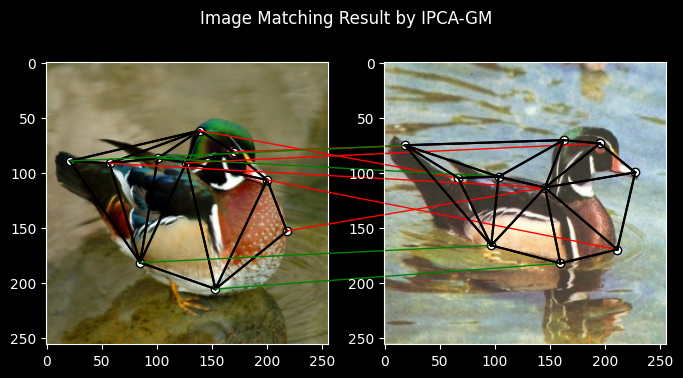

In [33]:
X = pygm.ipca_gm(node1, node2, A1, A2, pretrain='voc')
X = pygm.hungarian(X)

plt.figure(figsize=(8, 4))
plt.suptitle('Image Matching Result by IPCA-GM')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img1, kpts1, A1)
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img2, kpts2, A2)
for i in range(X.shape[0]):
    j = torch.argmax(X[i]).item()
    con = ConnectionPatch(xyA=kpts1[:, i], xyB=kpts2[:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)

In [34]:
path = '/home/dl2022/yyr/Cache/pretrained_params_vgg16_cie_voc.pt'
#path = pygm.utils.download('vgg16_cie_voc_pytorch.pt', 'https://drive.google.com/u/0/uc?export=download&confirm=Z-AR&id=1oRwcnw06t1rCbrIN_7p8TJZY-XkBOFEp')
cnn.load_state_dict(torch.load(path, map_location=map_location), strict=False)

with torch.set_grad_enabled(False):
    feat1_local, feat1_global = cnn(torch_img1)
    feat2_local, feat2_global = cnn(torch_img2)

In [35]:
def l2norm(node_feat):
    return torch.nn.functional.local_response_norm(
        node_feat, node_feat.shape[1] * 2, alpha=node_feat.shape[1] * 2, beta=0.5, k=0)

feat1_local = l2norm(feat1_local)
feat1_global = l2norm(feat1_global)
feat2_local = l2norm(feat2_local)
feat2_global = l2norm(feat2_global)

In [36]:
feat1_local_upsample = torch.nn.functional.interpolate(feat1_local, obj_resize, mode='bilinear')
feat1_global_upsample = torch.nn.functional.interpolate(feat1_global, obj_resize, mode='bilinear')
feat2_local_upsample = torch.nn.functional.interpolate(feat2_local, obj_resize, mode='bilinear')
feat2_global_upsample = torch.nn.functional.interpolate(feat2_global, obj_resize, mode='bilinear')
feat1_upsample = torch.cat((feat1_local_upsample, feat1_global_upsample), dim=1)
feat2_upsample = torch.cat((feat2_local_upsample, feat2_global_upsample), dim=1)
num_features = feat1_upsample.shape[1]

In [37]:
rounded_kpts1 = torch.round(kpts1).to(dtype=torch.long)
rounded_kpts2 = torch.round(kpts2).to(dtype=torch.long)
node1 = feat1_upsample[0, :, rounded_kpts1[0], rounded_kpts1[1]].t() # shape: NxC
node2 = feat2_upsample[0, :, rounded_kpts2[0], rounded_kpts2[1]].t() # shape: NxC

In [38]:
kpts1_dis = (kpts1.unsqueeze(1) - kpts1.unsqueeze(2))
kpts1_dis = torch.norm(kpts1_dis, p=2, dim=0).detach()
kpts2_dis = (kpts2.unsqueeze(1) - kpts2.unsqueeze(2))
kpts2_dis = torch.norm(kpts2_dis, p=2, dim=0).detach()

Q1 = torch.exp(-kpts1_dis / obj_resize[0]).unsqueeze(-1).to(dtype=torch.float32)
Q2 = torch.exp(-kpts2_dis / obj_resize[0]).unsqueeze(-1).to(dtype=torch.float32)

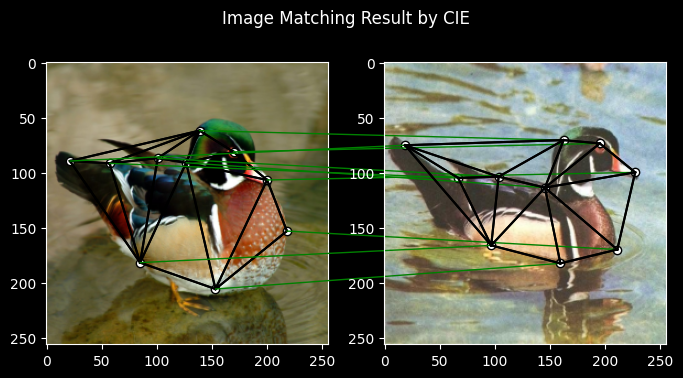

In [39]:
X = pygm.cie(node1, node2, A1, A2, Q1, Q2, pretrain='voc')
X = pygm.hungarian(X)

plt.figure(figsize=(8, 4))
plt.suptitle('Image Matching Result by CIE')
ax1 = plt.subplot(1, 2, 1)
plot_image_with_graph(img1, kpts1, A1)
ax2 = plt.subplot(1, 2, 2)
plot_image_with_graph(img2, kpts2, A2)
for i in range(X.shape[0]):
    j = torch.argmax(X[i]).item()
    con = ConnectionPatch(xyA=kpts1[:, i], xyB=kpts2[:, j], coordsA="data", coordsB="data",
                          axesA=ax1, axesB=ax2, color="red" if i != j else "green")
    plt.gca().add_artist(con)

In [40]:
class GMNet(torch.nn.Module):
    def __init__(self):
        super(GMNet, self).__init__()
        self.gm_net = pygm.utils.get_network(pygm.pca_gm, pretrain=False) # fetch the network object
        self.cnn = CNNNet(vgg16_cnn)

    def forward(self, img1, img2, kpts1, kpts2, A1, A2):
        # CNN feature extractor layers
        feat1_local, feat1_global = self.cnn(img1)
        feat2_local, feat2_global = self.cnn(img2)
        feat1_local = l2norm(feat1_local)
        feat1_global = l2norm(feat1_global)
        feat2_local = l2norm(feat2_local)
        feat2_global = l2norm(feat2_global)

        # upsample feature map
        feat1_local_upsample = torch.nn.functional.interpolate(feat1_local, obj_resize, mode='bilinear')
        feat1_global_upsample = torch.nn.functional.interpolate(feat1_global, obj_resize, mode='bilinear')
        feat2_local_upsample = torch.nn.functional.interpolate(feat2_local, obj_resize, mode='bilinear')
        feat2_global_upsample = torch.nn.functional.interpolate(feat2_global, obj_resize, mode='bilinear')
        feat1_upsample = torch.cat((feat1_local_upsample, feat1_global_upsample), dim=1)
        feat2_upsample = torch.cat((feat2_local_upsample, feat2_global_upsample), dim=1)

        # assign node features
        rounded_kpts1 = torch.round(kpts1).to(dtype=torch.long)
        rounded_kpts2 = torch.round(kpts2).to(dtype=torch.long)
        node1 = feat1_upsample[0, :, rounded_kpts1[0], rounded_kpts1[1]].t()  # shape: NxC
        node2 = feat2_upsample[0, :, rounded_kpts2[0], rounded_kpts2[1]].t()  # shape: NxC

        # PCA-GM matching layers
        X = pygm.pca_gm(node1, node2, A1, A2, network=self.gm_net) # the network object is reused
        return X

model = GMNet()

In [41]:
optim = torch.optim.Adam(model.parameters(), lr=1e-3)

In [42]:
X = model(torch_img1, torch_img2, kpts1, kpts2, A1, A2)

In [43]:
X_gt = torch.eye(X.shape[0])
loss = pygm.utils.permutation_loss(X, X_gt)
print(f'loss={loss:.4f}')

loss=3.0207


In [44]:
loss.backward()

[0.0001196596203953959, 0.002869819989427924, 0.0001775741984602064, 0.0031664869748055935, 0.00021434816881082952, 0.0051178173162043095, 1.4969495168770663e-05, 4.6410903451032937e-05, 9.724389383336529e-05, 0.003972421865910292, 0.0001317093410762027, 0.002939708763733506, 0.000454989931313321, 1.3165287526817337e-08, 0.0007103235111571848, 0.0005751337157562375, 0.00016360582958441228, 4.668041064803674e-09, 0.002173415385186672, 0.0011863980907946825, 0.00022878224262967706, 2.2524773157783784e-09, 0.0015054221730679274, 0.001180260325782001, 0.00019050513219553977, 2.6751623138920877e-09, 0.0017024887492880225, 0.0009677921188995242, 0.00018319727678317577, 1.1210065098410382e-09, 0.0014729185495525599, 0.0010438717436045408, 0.00015602500934619457, 1.4659959912677323e-09, 0.0015236730687320232, 0.0011335347080603242, 0.00016825110651552677, 1.8122687794885906e-09, 0.0018590607214719057, 0.0010216368827968836, 0.0001521408703410998, 5.19256415643099e-10, 0.0017183078452944756, 0.

<StemContainer object of 3 artists>

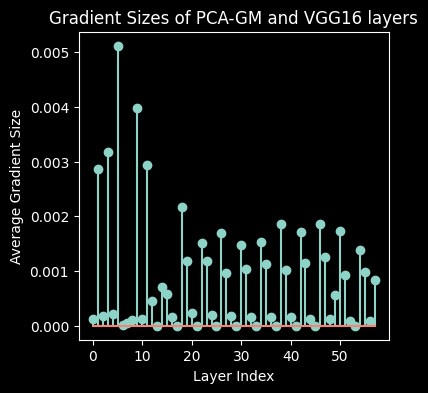

In [45]:
plt.figure(figsize=(4, 4))
plt.title('Gradient Sizes of PCA-GM and VGG16 layers')
plt.gca().set_xlabel('Layer Index')
plt.gca().set_ylabel('Average Gradient Size')
grad_size = []
for param in model.parameters():
    grad_size.append(torch.abs(param.grad).mean().item())
print(grad_size)
plt.stem(grad_size)

In [46]:
optim.step()
optim.zero_grad()